# **Project: Amazon Product Recommendation System**


--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------
The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, **Google Colab** is used for this project.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811627 sha256=a3489623189e7f6bd6ee347d30bdcac461fb16900a6bd3baaaae1158d4b7bcf7
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
# Read the data without headers
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Electronics.csv', header=None)

# Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Drop the column 'timestamp'
data.drop(columns=['timestamp'], inplace=True)

# Copy the data to another DataFrame called 'df'
df = data.copy(deep=True)

In [5]:
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [11]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Observations**: After filtering the dataset to consider users who have given at least 50 ratings and products that have at least 5 ratings, there are now 65,290 users remaining to be used for building the recommendation system.

### **Data types**

In [12]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations**: In the dataset, there are three columns and 65,290 observations. The columns are 'user_id', 'prod_id', and 'rating'. The 'user_id' and 'prod_id' columns are of the object data type, even though 'prod_id' may appear numerical. This suggests that there might be some 'prod_id' entries containing characters or a combination of numerical and character values.



### **Checking for missing values**

In [13]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()

# Display the count of missing values in each column
print(missing_values)

user_id    0
prod_id    0
rating     0
dtype: int64


**Observations**: Based on the above output, it can be concluded that there are no missing values present in the dataset.

### **Summary Statistics**

In [14]:
# Summary statistics of 'rating' variable and provide observations
df_final["rating"].describe().T

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations**: The presence of the minimum rating of 1 shows that there are some products that have received the lowest rating. The fact that both the 75th percentile and the maximum rating is 5 indicates that a significant portion of the products (at least 75%) have received the highest possible rating of 5. This suggests that many products are highly rated by users. The mean rating of approximately 4.29 suggests that, on average, the products are well-received, as it is closer to the maximum rating of 5

### **Checking the rating distribution**

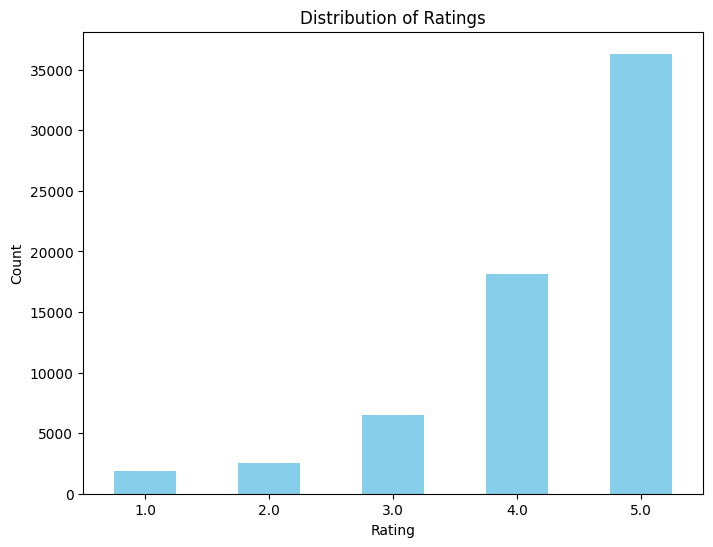

In [15]:
# Create the bar plot and provide observations

# Create the bar plot for the "rating" column
plt.figure(figsize=(8, 6))
df_final['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')

# Customize the plot
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks(rotation=0)

# Show the plot
plt.show()

**Observations**: The ratings in the dataset are diverse, covering a range of values from 1 to 5, suggesting users' varying opinions on the products. The distribution of ratings is slightly left-skewed due to a few products with lower ratings pulling the mean slightly down. Interestingly, a majority of the products have received the highest rating of 5, indicating a high level of satisfaction for these items.

### **Checking the number of unique users and items in the dataset**

In [16]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of unique users
num_unique_users = df_final["user_id"].nunique()

# Number of unique items
num_unique_items = df_final["prod_id"].nunique()

# Print the results
print("Number of unique users:", num_unique_users)
print("Number of unique items:", num_unique_items)

Number of unique users: 1540
Number of unique items: 5689


**Observations**:

*   There are 1,540 unique users. This means that there are 1,540 different individuals who have provided ratings for the products. Each user may have rated one or more items, and some users may have rated multiple items.
*   Also, there are 5,689 unique items. This indicates that there are 5,689 distinct products or items for which ratings are available. Each item may have received ratings from one or more users.



### **Users with the most number of ratings**

In [17]:
# Top 10 users based on the number of ratings

# Group the DataFrame by "user_id" and count the number of ratings for each user
user_ratings_count = df_final.groupby('user_id')['rating'].count()

# Sort the users based on the number of ratings in descending order and get the top 10 users
top_10_users = user_ratings_count.sort_values(ascending=False).head(10)

# Print the top 10 users and their corresponding count of ratings
print("Top 10 users with the most ratings:")
print(top_10_users)

Top 10 users with the most ratings:
user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: rating, dtype: int64


**Observations**: The user with ID **ADLVFFE4VBT8** stands out as the most highly engaged user, having provided a total of 295 ratings. Additionally, the users listed in the top 10 demonstrate strong loyalty to the product or brand, consistently offering valuable feedback through their ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [18]:
# Calculate the average rating for each product
average_ratings = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_ratings = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average_Rating': average_ratings, 'Rating_Count': count_ratings})

# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values(by='Average_Rating', ascending=False, inplace=True)

# See the first five records of the "final_rating" dataset
final_rating.head()

,Average_Rating,Rating_Count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [19]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def get_top_n_products(df, n, min_interactions=5):

    # Finding products with minimum number of interactions
    recommended_products = final_rating[final_rating['Rating_Count'] >= min_interactions]

    # Sorting values with respect to average rating
    top_n_products = recommended_products.nlargest(n, 'Average_Rating')

    return top_n_products


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [20]:
# Calling the get_top_n_products function to get the top 5 products for recommendation
# based on the highest average rating, considering only products with at least 50 interactions (ratings).
get_top_n_products(df_final, 5, min_interactions=50)

,Average_Rating,Rating_Count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [21]:
# Calling the get_top_n_products function to get the top 5 products for recommendation
# based on the highest average rating, considering only products with at least 100 interactions (ratings).
get_top_n_products(df_final, 5, min_interactions=100)

,Average_Rating,Rating_Count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


**Observation**: Product#**B003ES5ZUU** is among the top five products recommended with both 50 and 100 interactions using the popularity recommendation system. This product can be recommended for new users.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [22]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [23]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [24]:
# Step 1: Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Step 2: Loading the rating dataset
# Load the DataFrame 'df_final' into the required format for Surprise library
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Step 3: Splitting the data into train and test datasets
# Split the data into a training set and a test set with a 70-30 split
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [25]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # Using cosine similarity for user-user collaborative filtering
    'user_based': True  # User-User Collaborative Filtering
}

# Initialize the KNNBasic model using sim_options, Verbose=False, and setting random_state=1
user_user_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Step 3: Fit the model on the training data
user_user_model.fit(trainset)

# Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function
precision_recall_at_k(user_user_model)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Observations**:


*   The model's predictions are relatively close to the true ratings, as indicated by the RMSE value of **1.0250**.
*   The model's top-10 recommendations have high accuracy, with a precision of **86%**, indicating that the majority of the recommended items or products are relevant to the users.
*   Moreover, the system provides good coverage of relevant items, as indicated by a recall of **78.3%**, meaning that many of the relevant items or products are being recommended.
*   The F1 score of **82%** suggests a good balance between precision and recall, indicating that the model is performing well overall. This can be improved further by using GridSearchCV by tuning different hyperparameters.








Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [26]:
# Predicting rating for a sample user with an interacted product
user_user_model.predict('A3LDPF5FMB782Z','1400501466',r_ui=5,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Observations**: The provided output demonstrates that the actual rating for the product is **5**, while the user-user similarity model predicts a rating of **3.00**. This means that the model's prediction is significantly lower than the user's actual rating for the product.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [27]:
# Find unique user_id where prod_id is not equal to "1400501466"

# Filter the DataFrame to get unique user IDs where prod_id is not equal to "1400501466"
df_final[df_final['prod_id'] != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

In [28]:
unique_user_ids = df_final[df_final['prod_id'] != "1400501466"]["user_id"].unique()

# Check if "A34BZM6S9L7QI4" is in the unique user IDs
is_user_present = "A34BZM6S9L7QI4" in unique_user_ids

# Print the result
print(is_user_present)

True


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [29]:
# Predicting rating for a sample user with a non interacted product
user_user_model.predict('A34BZM6S9L7QI4','1400501466',verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**: It can be seen from the above output that, the rating predicted for the product the user has not seen is high for the user-user similarity model. This suggests that the model might be overestimating the ratings for unseen products, indicating a potential bias towards higher ratings.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [30]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],             # Number of neighbors to consider (k)
    'min_k': [1, 5, 10],            # Minimum number of neighbors to have to make a prediction
    'sim_options': {
        'name': ['cosine', 'pearson','pearson_baseline','msd'],   # Similarity measure: cosine, pearson, pearson baseline or msd
        'user_based': [True],     # User-User Collaborative Filtering
        'min_support':[2,4]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters and fitting the data
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search.fit(data)

# Best RMSE score
best_rmse_score = grid_search.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']

# Printing results
print("Best RMSE score:", best_rmse_score)
print("Best combination of parameters:", best_params)


Best RMSE score: 0.9805174967384488
Best combination of parameters: {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [31]:
# Using the optimal similarity measure for user-user based collaborative filtering
optimal_similarity_measure = {'name': 'cosine',
               'user_based': True, "min_support":2}


# Creating an instance of KNNBasic with optimal hyperparameter values
user_user_optimized_model = KNNBasic(k=30, min_k=5, sim_options=optimal_similarity_measure, random_state=1, verbose=False)

# Training the algorithm on the trainset
user_user_optimized_model.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(user_user_optimized_model)

RMSE: 0.9716
Precision:  0.841
Recall:  0.803
F_1 score:  0.822


**Observations**: After tuning the hyperparameters, the user-user similarity-based recommendation model's performance has improved. The Root Mean Squared Error (**RMSE**) score has decreased, indicating that the model's predictions are now closer to the actual ratings compared to the model before tuning. The **Recall** score has slightly increased, indicating that the model is recommending more relevant items to users. However, the **Precision** score has decreased slightly, suggesting that the proportion of correctly recommended items among all recommended items has slightly reduced. Despite this, the overall effectiveness of the model has improved, as evident from the slightly increased F1 score, which balances Precision and Recall. The **F_1** score improvement of **0.2%** further supports the enhanced performance of the model after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [32]:
# Use user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_user_optimized_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [33]:
# Use user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_user_optimized_model.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**:

*   The rating predicted for the user with `userId="A3LDPF5FMB782Z"` and `prod_id="1400501466"` using the optimized model is **4.29**, which is significantly closer to the actual rating of **5**. This clear improvement is evident when compared to the previous model, which, before tuning, predicted a rating of **3**.
*   In addition, the optimized model predicts a rating of **4.29** for a product not seen by the user, which is lower compared to the predictions made by the model before tuning. This indicates that the optimized model exhibits less bias towards higher ratings.








### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [34]:
# 0 is the inner id of the above user
user_user_optimized_model.get_neighbors(0,5)

[54, 71, 91, 113, 156]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [35]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [36]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top5_recommendations = get_recommendations(df_final,'A3LDPF5FMB782Z', 5, user_user_optimized_model)

In [37]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
cols = ['prod_id', 'predicted_ratings']
pd.DataFrame(top5_recommendations, columns = cols )

,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [38]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # Using cosine similarity for item-item collaborative filtering
    'user_based': False  # Item-Item Collaborative Filtering
}

# Initialize the KNNBasic model using sim_options, Verbose=False, and setting random_state=1
item_item_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Step 3: Fit the model on the training data
item_item_model.fit(trainset)

# Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function
precision_recall_at_k(item_item_model)


RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**Observations**:

*   In this case, the **RMSE** value is **1.0232**, which means, on average, the model's predictions have an error of approximately 1.0232 in rating values. This is slightly lower than the user-user model before tuning.
*    The **Precision** value of 0.835 indicates that **83.5%** of the items recommended by the model are relevant to the users which is lower compared to the user-user model before tuning.
*    The Recall value of 0.758 means that the model has successfully recommended **75.8%** of the relevant items in the top-10 recommendations which is lower compared to the user-user model before tuning.
*    The **F_1** score value of **0.795** indicates a good balance between precision and recall but it is lower compared to the user-user model before tuning.





Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [39]:
# Predicting rating for a sample user with an interacted product
item_item_model.predict('A3LDPF5FMB782Z','1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.32   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

**Observations**: The **item-item similarity model** demonstrates its ability to make accurate predictions, as evident from the output above, where the actual rating is **5**, and the predicted rating is **4.32**. The performance of this model's prediction surpasses both the user-user model before and after tuning.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [40]:
# Predicting rating for a sample user with a non interacted product
item_item_model.predict('A34BZM6S9L7QI4','1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**: The **item-item similarity model** predicted a rating of **4.29** for a product that the user has not seen. This predicted rating is lower compared to the user-user similarity model before tuning. The lower predicted rating suggests that the item-item similarity model is slightly less biased towards higher ratings.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],             # Number of neighbors to consider (k)
    'min_k': [1, 5, 10],            # Minimum number of neighbors to have to make a prediction
    'sim_options': {
        'name': ['cosine', 'msd'],   # Similarity measure: cosine or msd
        'user_based': [False],     # Item-Item Collaborative Filtering
        'min_support':[2,4]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters and fitting the data
grid_search1 = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search1.fit(data)

# Best RMSE score
best_rmse_score1 = grid_search1.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params1 = grid_search1.best_params['rmse']

# Printing results
print("Best RMSE score:", best_rmse_score1)
print("Best combination of parameters:", best_params1)

Best RMSE score: 0.9848749709007536
Best combination of parameters: {'k': 20, 'min_k': 5, 'sim_options': {'name': 'msd', 'user_based': False, 'min_support': 2}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [42]:
# Using the optimal similarity measure for item-item based collaborative filtering
optimal_similarity_measure = {'name': 'msd',
               'user_based': False, "min_support":2}

# Creating an instance of KNNBasic with optimal hyperparameter values
item_item_optimized_model = KNNBasic(k=20, min_k=5, sim_options=optimal_similarity_measure, random_state=1, verbose=False)

# Training the algorithm on the trainset
item_item_optimized_model.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(item_item_optimized_model)

RMSE: 0.9782
Precision:  0.832
Recall:  0.798
F_1 score:  0.815


**Observations**: After tuning the hyperparameters, the  F_1 score of the tuned model has significantly improved, increasing from **0.795** to **0.815**. Additionally, the **RMSE** value has decreased from **1.0232** to **0.9782**. These improvements indicate that the tuned model outperforms the baseline model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [43]:
# Use item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
item_item_optimized_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [44]:
# Use item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
item_item_optimized_model.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations**:

*   The **item-item optimized model** predicted a rating of **4.29** for the user with ID "**A3LDPF5FMB782Z**" and the product with ID "**1400501466**," which is slightly lower than the item-item baseline model's prediction of **4.32**. However, the actual rating for this user and product is 5. This implies that the baseline model is performing slightly better than the optimized model since it is closer to the actual rating of 5 in this particular case.
*   Additionally, the **item-item optimized model** predicted the same rating for a product not seen by the user as the baseline model. This similarity in predicted ratings suggests that the item-item optimized model's predictions for unseen products align closely with the baseline model's predictions.



### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [45]:
# 0 is the inner id of the above user
item_item_optimized_model.get_neighbors(0,5)

[315, 1282, 534, 189, 405]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [46]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
top5_recommendations = get_recommendations(df_final,'A1A5KUIIIHFF4U', 5, item_item_optimized_model)

In [47]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
cols = ['prod_id', 'predicted_ratings']
pd.DataFrame(top5_recommendations, columns = cols )

,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [48]:
# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**Observations**:

*   The model's predictions are relatively close to the true ratings, as indicated by the low RMSE value of **0.8989**.
*   The model's top-10 recommendations have high accuracy, with a **Precision** of **86%** indicating that the majority of the recommended items are relevant to the users.
*   The system provides good coverage of relevant items, as indicated by a **Recall** of **79.7%**, meaning that many of the relevant items are being recommended.
*   The **F1 score** of 0.827 suggests a good balance between precision and recall, indicating that the model is performing well overall in making relevant and accurate recommendations.







**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [49]:
# Making prediction
svd_model.predict('A3LDPF5FMB782Z','1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.070652912318144, details={'was_impossible': False})

**Observations**: The **matrix factorization-based** baseline model predicted the rating of **4.07**, while the actual rating is **5**. This prediction is relatively close to the actual rating, indicating that the model's performance is quite good.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [50]:
# Making prediction
svd_model.predict('A34BZM6S9L7QI4','1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.39   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.3949263041205775, details={'was_impossible': False})

**Observations**: The **matrix factorization-based** baseline model predicted a rating of **4.39** for a product that the user has not seen. This suggests that the model is slightly less biased towards higher ratings, as the predicted rating is below the maximum rating of **5**.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [51]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30, 40],  # Number of iterations for SGD optimization
              'lr_all': [0.001, 0.003, 0.005, 0.01],  # Learning rate for SGD optimization
              'reg_all': [0.2, 0.3, 0.4, 0.6]}  # Regularization term for all parameters

# Creating a Surprise Dataset object from the data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Performing 3-fold gridsearch cross-validation and fitting the data
grid_search2 = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)  # n_jobs=-1 enables parallel processing
grid_search2.fit(data)

# Best RMSE score
best_rmse_score2 = grid_search2.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params2 = grid_search2.best_params['rmse']

# Printing results
print("Best RMSE score:", best_rmse_score2)
print("Best combination of parameters:", best_params2)


Best RMSE score: 0.8984803114848748
Best combination of parameters: {'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.3}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [52]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized_model = SVD(n_epochs=40, lr_all=0.005, reg_all=0.3, random_state=1)

# Train the algorithm on the trainset
svd_optimized_model=svd_optimized_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized_model)

RMSE: 0.8897
Precision:  0.862
Recall:  0.799
F_1 score:  0.829


**Observations**: After tuning the hyperparameters of the **SVD model**, the RMSE score has declined slightly by **0.92%**, indicating improved accuracy in the model's predictions. Additionally, the F1 score has increased slightly by **0.2%**, suggesting enhanced overall performance in terms of precision and recall balance.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [53]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.06   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.055408085578538, details={'was_impossible': False})

In [54]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized_model.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.13   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.131635127560819, details={'was_impossible': False})

**Observations**:

*   The rating predicted for the user using the optimized model is **4.06**, while the prediction for the baseline model is **4.07**, for an actual rating of **5**. This comparison indicates that the baseline model's performance is marginally better than the optimized model.
*   Moreover, the rating predicted for a product that the user has not seen is **4.13**, which is lower than the baseline model's prediction. This suggests that the optimized model is less biased towards giving the highest ratings of **5**. The lower predicted rating indicates that the optimized model is making more conservative predictions for unseen products, showing a reduction in overestimating ratings compared to the baseline model.



# **Conclusion**:

*   The "Model-Based Collaborative Filtering - Matrix Factorization" models (both tuned and untuned) show the lowest RMSE values, indicating that they provide more accurate predictions compared to other models.

* The precision, recall, and F1 scores for most models are in a similar range, indicating comparable recommendation effectiveness. However, it is worth noting that the item-item baseline model's prediction of a user's actual rating was the closest.

*   The "Tuned Model-Based Collaborative Filtering - Matrix Factorization" model performs slightly better than the untuned version, with slightly lower RMSE and slightly higher precision, recall, and F1 scores.

# **Recommendations**:

*   The "Model-Based Collaborative Filtering - Matrix Factorization" model, particularly the tuned version, appears to be the most effective and accurate recommendation system among those tested. It is recommended to use this model for making personalized recommendations.


*   If computational resources allow, hyperparameter tuning can be considered for the "Model-Based Collaborative Filtering - Matrix Factorization" model to potentially achieve even better performance


*   Also, continuous monitoring and gathering user feedback(more data) to validate the performance of the recommended system and identify opportunities for improvement.


*   Hybrid recommendation approaches can be explored which combines the strengths of multiple models to potentially achieve even better recommendation accuracy and coverage.




